In [1]:
# TODO: Speed up the newsiness calculation by using multiprocessing
# TODO: Convert datetimes to eastern timezone from UTC
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from app.models import Session, Headline, Article, Agency

In [2]:
s = Session()
data = s.query(Headline.id, Article.id, Agency.name, Headline.title, Headline.first_accessed, Headline.last_accessed)\
    .join(Headline.article).join(Article.agency).all()
s.close()

In [3]:
raw_df = pd.DataFrame(data, columns=['hid', 'aid', 'agency', 'title', 'first', 'last'])
print(raw_df.shape)

(1175204, 6)


In [31]:
from tqdm import tqdm
tqdm.pandas()
# Take only the first 1000 rows for now
# df = raw_df.head(10000).copy()
df = raw_df.copy()
# Create a column that is a list of datetimes corresponding to the hours from first access to last access.
# Make sure to zero out the minutes and seconds.
df['first'] = df['first'].dt.floor('h')
df['last'] = df['last'].dt.floor('h')

In [32]:
# This takes too long, we're doing it the long way around
# df['hours'] = df.progress_apply(lambda x: pd.date_range(x['first'], x['last'], freq='h'), axis=1)
# Create first_ts and last_ts for each headline, converting them to unix timestamps
df['first_ts'] = df['first'].apply(lambda x: x.timestamp())
df['last_ts'] = df['last'].apply(lambda x: x.timestamp())

In [33]:
# Now we create a list of integers from first_ts to last_ts for each headline, intervals of 3600 seconds
df['hours'] = df.progress_apply(lambda x: np.arange(x['first_ts'], x['last_ts'], 3600, dtype=int), axis=1)

100%|██████████| 1175204/1175204 [00:06<00:00, 179947.58it/s]


In [34]:
# Next we explode the hours column so that each row corresponds to a single hour
df = df.explode('hours')
# Reset the index
df.reset_index(drop=True, inplace=True)
# Convert the hours column to a datetime
df['hours'] = pd.to_datetime(df['hours'], unit='s')

In [35]:
df.sample(5)

,hid,aid,agency,title,first,last,first_ts,last_ts,hours
1285133,5020,3958,Fox News,RED FLAGS,2024-02-16 23:00:00,2024-05-18 12:00:00,1.708124e+09,1.716034e+09,2024-02-22 21:00:00
487393,1637,1567,HuffPost,These Amazon Presidents Day Deals Are Almost T...,2024-02-16 20:00:00,2024-02-20 12:00:00,1.708114e+09,1.708430e+09,2024-02-19 08:00:00
23189559,1064077,664311,The Times of India,IPL Today Match RCB vs PBKS: Dream11 team pred...,2024-05-09 05:00:00,2024-05-09 11:00:00,1.715231e+09,1.715252e+09,2024-05-09 10:00:00
12223950,441648,251333,MSNBC,Judge Cannon is on the verge of being appealed...,2024-03-19 19:00:00,2024-04-03 19:00:00,1.710875e+09,1.712171e+09,2024-03-22 20:00:00
25421798,1213050,777941,The Washington Post,Sam Alito’s flag flew upside down. Are his eth...,2024-05-19 14:00:00,2024-05-20 12:00:00,1.716127e+09,1.716206e+09,2024-05-20 10:00:00


In [36]:
def get_newsiness(headlines):
    tfidf = TfidfVectorizer(stop_words='english')
    cosim = cosine_similarity(tfidf.fit_transform(headlines))
    # Zero out the diagonal
    np.fill_diagonal(cosim, 0)
    # Zero out all values less than 0.5
    cosim[cosim < 0.5] = 0
    # Take the # of non-zero values as the newsiness
    return np.count_nonzero(cosim)

In [37]:
# Group by the hours column and apply the get_newsiness function to the titles
# Eventually we can speed this up with multiprocessing I think.
# For now though, this is fine. More than a million headlines Seems to be taking under 20 minutes.
# Recalculation will be expensive! But we won't do it often.
# We'll save the results as a csv for incorporation in the website.
# Simple solutions are best.
newsiness = df.groupby('hours')['title'].progress_apply(get_newsiness)
# It took almost 22 minutes for the first run.

# Now create a dataframe matching hours to newsiness
newsiness_df = pd.DataFrame(newsiness).reset_index()

100%|██████████| 2395/2395 [21:41<00:00,  1.84it/s]


In [38]:
# Now create a column of the day of the week
newsiness_df['day'] = newsiness_df['hours'].dt.day_name()
# Create a column of the hour of the day irrespective of date
newsiness_df['hour'] = newsiness_df['hours'].dt.hour
# Create a df of group by hour and day and take the mean of the newsiness and the median of the newsiness
newsiness_df = newsiness_df.groupby(['hour', 'day'])['title'].agg(['mean', 'median']).reset_index()
newsiness_df.head()

,hour,day,mean,median
0,0,Friday,12087.857143,12969.0
1,0,Monday,11507.428571,11944.0
2,0,Saturday,12589.600000,13154.0
3,0,Sunday,11808.133333,12506.0
4,0,Thursday,12950.142857,13109.0


In [ ]:
newsiness_df.to_csv('../newsiness.csv', index=False)

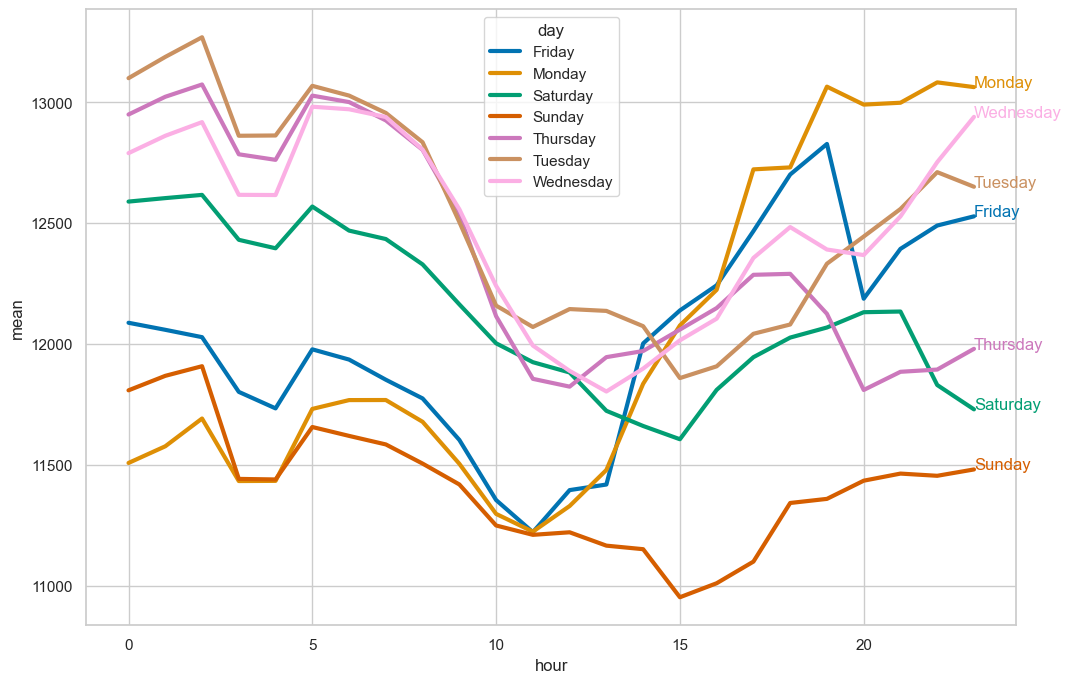

In [44]:
# Plot the mean newsiness by hour
import seaborn as sns
import matplotlib.pyplot as plt
# Colorblind friendly
sns.set_palette('colorblind')
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='hour', y='mean', hue='day', lw=3)
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['mean'].values[-1], day, fontsize=12, color=sns.color_palette('colorblind')[i])
plt.show()

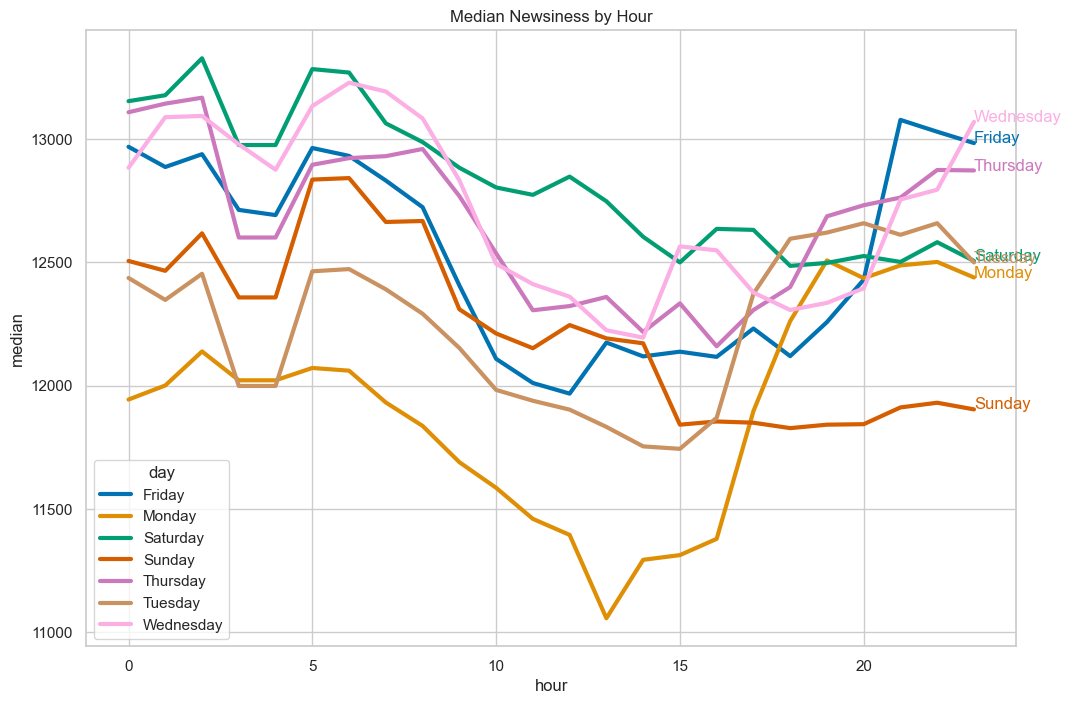

In [59]:
# Plot the median newsiness by hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='hour', y='median', hue='day', lw=3)
# Add a title
plt.title('Median Newsiness by Hour')
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['median'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()


In [45]:
# Rank the days by newsiness
newsiness_df.groupby('day')['mean'].mean().sort_values(ascending=False)

day
Tuesday      12535.482143
Wednesday    12492.797619
Thursday     12378.333333
Saturday     12128.322222
Friday       12009.255159
Monday       12008.732143
Sunday       11409.779365
Name: mean, dtype: float64

In [47]:
# Rank the hours by newsiness
newsiness_df.groupby('hour')['mean'].mean().sort_values(ascending=False)

hour
2     12501.149660
1     12454.488435
5     12430.557823
0     12404.839456
6     12399.133333
7     12351.544218
23    12339.042177
22    12316.627211
19    12309.874830
21    12280.385034
8     12247.262585
18    12236.627211
3     12196.032653
20    12195.254422
4     12177.782313
17    12131.394558
9     12041.016327
16    11921.141497
15    11815.187755
14    11798.745578
10    11773.741497
12    11669.016327
13    11667.261224
11    11642.586395
Name: mean, dtype: float64

In [48]:
# Find the newsiest hourday
newsiness_df[newsiness_df['mean'] == newsiness_df['mean'].max()]

,hour,day,mean,median
19,2,Tuesday,13270.0,12454.0


In [51]:
# Group by morning, afternoon, evening, night and find the busiest period on which day
newsiness_df['period'] = pd.cut(newsiness_df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])
newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)

/var/folders/fd/vfz6tp5d6lg2p2jkv89sf3jm0000gn/T/ipykernel_61535/1575237050.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


day        period   
Tuesday    night        13046.880952
Monday     evening      13040.428571
Thursday   night        12945.952381
Wednesday  night        12828.190476
           evening      12596.142857
Tuesday    evening      12539.742857
Saturday   night        12514.577778
Friday     evening      12485.681905
Tuesday    morning      12445.142857
Wednesday  morning      12404.214286
Thursday   morning      12343.142857
Monday     afternoon    12178.142857
Friday     afternoon    12161.904762
Saturday   morning      12122.911111
Thursday   afternoon    12116.952381
Wednesday  afternoon    12110.309524
Tuesday    afternoon    12016.690476
Saturday   evening      11978.746667
Thursday   evening      11938.714286
Friday     night        11922.571429
Saturday   afternoon    11795.244444
Sunday     night        11655.400000
Monday     night        11605.428571
Friday     morning      11533.166667
Monday     morning      11466.428571
Sunday     evening      11438.200000
           mornin